# Time Series

A time series is a sequence representing time-dependent observations. This notebook outlines some definitions for processing and analyzing time series. This notebook is guided from the descriptions provided in [P. Senin, et al. (Feb. 2018)](https://dl.acm.org/citation.cfm?id=3051126)

In [1]:
# Overhead
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
from time_series_utils.comparisons import *
from time_series_utils.vectorize import *
from time_series_utils.time_series import TimeSeries,Subsequence
# Change math font to Computer Modern (LaTeX default)
#from matplotlib import rcParams
#rcParams['mathtext.fontset'] = 'cm'

## Time series and subsequences

If we have time series $T$, consisting of $m$ observations, then 

$$ T = T_1, ..., T_m $$

where $T_i$ is the $i^{\text{th}}$ measurement of $T$. Let's create a arbitrary time series that is a variation on the sine function. 

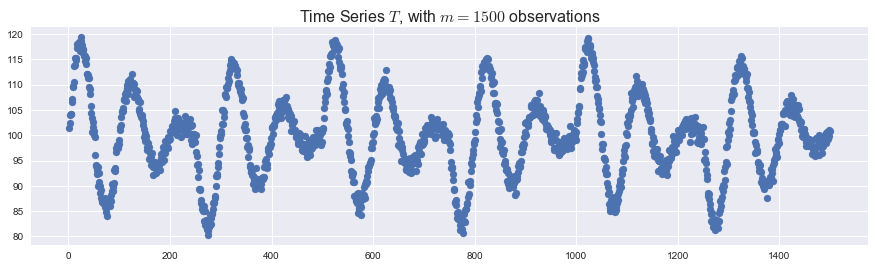

In [2]:
# Create a time series with m observations
m = 1500
times = np.arange(m)+1
periods = 15
multiplier = 0.5+0.5*signal.sawtooth(np.linspace(0,4*np.pi*periods/5,m),0)
observations = 100 + (20*np.sin(times*2*np.pi*periods/m)*multiplier) + np.random.normal(0,1,m)
T = TimeSeries(times,observations)
# Plot the time series
T.plot_timeseries(f'Time Series $T$, with $m={m}$ observations')
plt.show()

### Subsequences

A subsequence is a continuous subset of the points in $T$. If subsequence $C$ has length $n$ (where typically $n \ll m$) and starts at position $p \in \{1, ..., m-n+1\}$ then

$$ C = T_p, ... , T_{p+n-1} $$

A subsequence $C$ of time series $T$ is shaded in the plot below. It has length $n = 200$ and starts at $p = 200$.

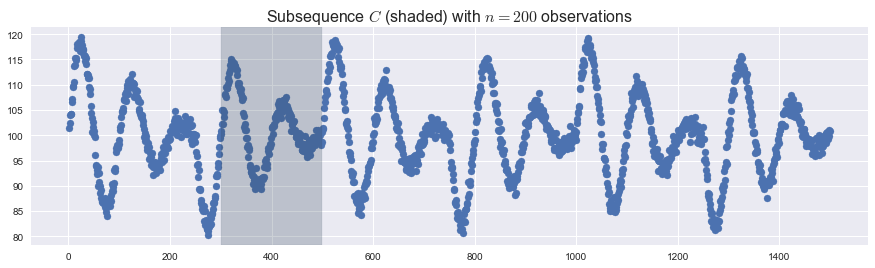

In [3]:
# Display a subsequence with length n starting at p
p = 300
n = 200
C = Subsequence(T,p,n)
# Shade the subsequence on the plot
C.plot_timeseries(f'Subsequence $C$ (shaded) with $n={n}$ observations')
C.shade_subsequence()
plt.show()

Since there are $m$ total points, there are $m-n+1$ total subsequences of length $n$. 

\begin{align} 
C_1&= C_1, ..., C_n \\
C_2&= C_2, ..., C_{n+1} \\
&... \\
C_p&= C_p, ..., C_{p+n-1} \\
&... \\
C_{m-n+1}&= C_{m-n+1}, ..., C_m
\end{align}

### $\boldsymbol{z}$-normalization 
The process of $z$-normalization allows better comparison between the structure of different time series subsequences (rather than their absolute differences). The process involves subtracting the mean of a subsequence from each point in the subsequence, and setting the standard deviation to 1.

$$ C_{\text{znorm}} = \frac{C - \mu_C}{\sigma_C} $$

For the shaded subsequence above:

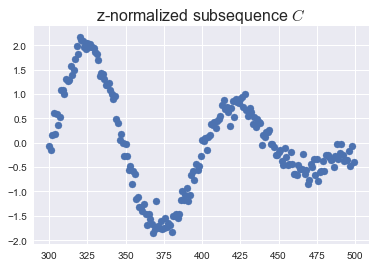

In [4]:
fig_znorm,ax_znorm = plt.subplots()
C.z_normalize()
ax_znorm.scatter(C.times,C.z_norm)
ax_znorm.set_title('z-normalized subsequence $C$',fontsize=16)
plt.show()

## Subsequence comparisons

We can compare subsequences by defining the distance between them. Subsequences are said to match if the distance between them is less than some threshold.

### Distance

The Euclidean distance between any two subsequences, $C$ and $D$, is given by the Euclidean norm

$$ \textit{Dist}(C,D) = \left|C - D\right| = \sqrt{\left(c_1-d_1\right)^2 + ... + \left(c_i-d_i\right)^2 + ... + \left(c_n-d_n\right)^2} $$

In [5]:
def euc_dist(C,D,use_z_norm=False):
    """Calculate the Euclidean distance between any two subsequences."""
    if use_z_norm:
        return np.linalg.norm(C.z_norm-D.z_norm)
    return np.linalg.norm(C.obs-D.obs)

Naturally, this means that subsequences that are more similar will have smaller distances. Here are two subsequences that both represent one complete period of the underlying sine function.

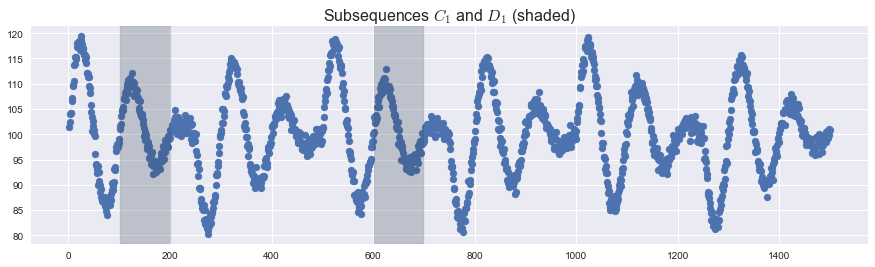

Subsequence z-normalized distance: 2.271


In [6]:
# C and B of length 100 starting at p=101 and p=601 respectively
n = 100
C1 = Subsequence(T,start=101,length=n)
D1 = Subsequence(T,start=601,length=n)
# Shade the subsequence on the plot
compare_subsequences(C1,D1,title=f'Subsequences $C_1$ and $D_1$ (shaded)',
                     z_norm='subsequences')

We can compare the distance between $C_1$ and $D_1$ to the distance of two other subsequences $C_2$ and $D_2$ which are shifted in phase from one another.

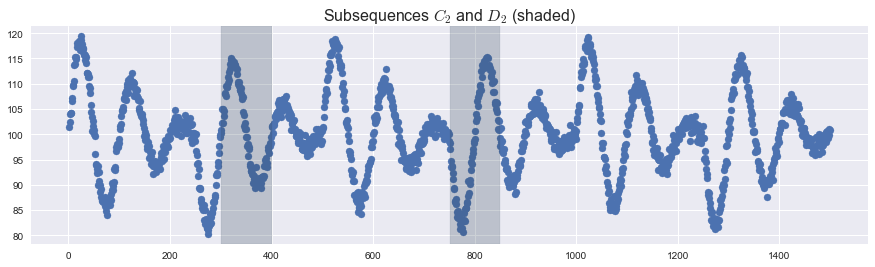

Subsequence z-normalized distance: 19.956


In [7]:
# B and C of length 100 starting at p=301 and p=751 respectively
n = 100
C2 = Subsequence(T,start=301,length=n)
D2 = Subsequence(T,start=751,length=n)
# Shade the subsequence on the plot
compare_subsequences(C2,D2,title=f'Subsequences $C_2$ and $D_2$ (shaded)',
                     z_norm='subsequences')

The distance for the phase-shifted subsequences is much greater.

### Matches

A subsequence is said to match another subsequence if the distance between the two is less than some threshold distance. If the threshold distance is a postive real number $h$, then $C$ matches $D$ if $\textit{Dist}\left(C,D\right) \leq h$.

Some matches will be trivial. A subsequence $C_i = T_i, ...,  T_{i+n}$ may have a very small Euclidean distance from $C_{i+1} = T_{i+1}, ..., T_{i+n+1}$ if each $T_j \in T$ is close to $T_{j+1}$. For this reason a **non-self-match** is defined as a match where the subsequences do not overlap. Mathematically, if $C$ and $D$ are both length $n$ subsequences and start at $p$ and $q$ respectively, a match where $\textit{Dist}\left(C,D\right) \leq h$ and $\left|p-q\right| \geq n$ is a non-self-match. The `nonselfmatch` function in the `time_series_utils.comparisons` module can test whether two subsequences are non-self-matches.

We use this function in the `find_subsequence_nonselfmatches` function to identify all of the non-self-matches to a subsequence in the entire time series. We can test the function on the original time series for three threshold values: 40, 20, and 10. With those thresholds, let's find all non-self-matches for the first 100 points. 

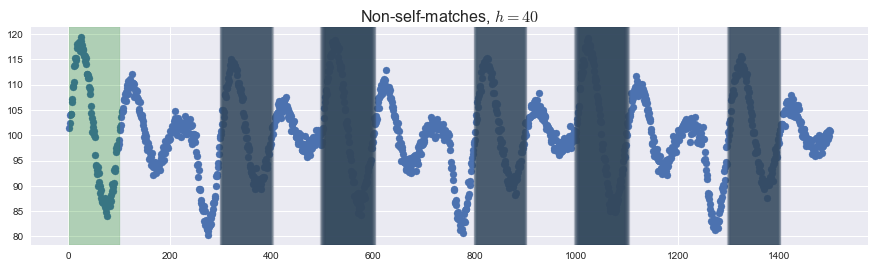

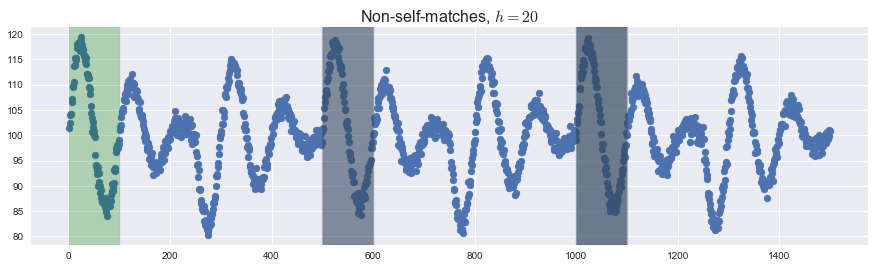

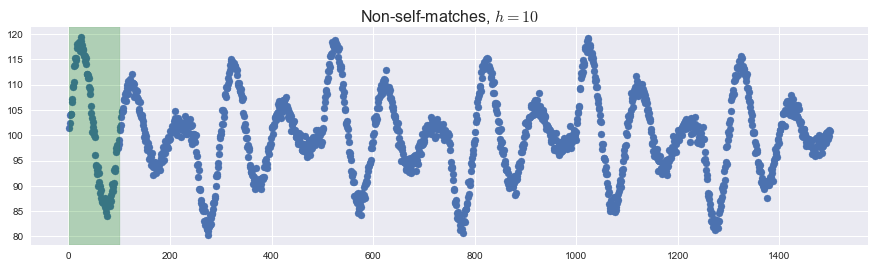

In [8]:
C = Subsequence(T,start=1,length=100)
for h in [40,20,10]:
    # Get an array of all the distances for matching subsequences
    nonselfmatches = find_subsequence_nonselfmatches(C,h)
    plot_nonselfmatches(C,nonselfmatches,title=f'Non-self-matches, $h = {h}$')

The first 100 points are shaded in green, and all non-self-matches are shaded in gray (overlapping non-self-matches will appear as darker shades of gray). While the threshold of 40 certainly shows some ability to identify similar patterns, it is clearly the least less stringent. A threshold of 10 is too low, and none of the other subsequences qualify as matches.

### Motifs

Patterns that occur frequently in a dataset are called motifs. The Senin paper describes two types of motifs: a _closest-pair time series motif_ and a _approximate-length time series motif_. The former is "the most similar pair of non-overlapping subsequences", whereas the latter is "a set of similar subsequences" which may overlap and which may not even all be the same length.

### Discords

Conversely, discords are patterns that occur rarely in a time series. The paper defines a discord as the subsequence $C \in T$ that has the largest Euclidean distance to its nearest non-self-match (citing the [2005 paper by Keogh, et al.](https://ieeexplore.ieee.org/document/1565683)). If we maintain a constant subsequence length, we can calculate the complete set of distances between non-self-matches. For each subsequence, we find the best non-self-match among the remaining subsequences. The discord is the worst of these non-self-matches—the non-self-match with the greatest distance. 

Since operations on the entire time series are much more computationally intensive, we will write a vectorized procedure for calculating the distances between every subsequence. The entire procedure can be completed using the `get_discord` function in the `time_series_utils.vectorize` module.

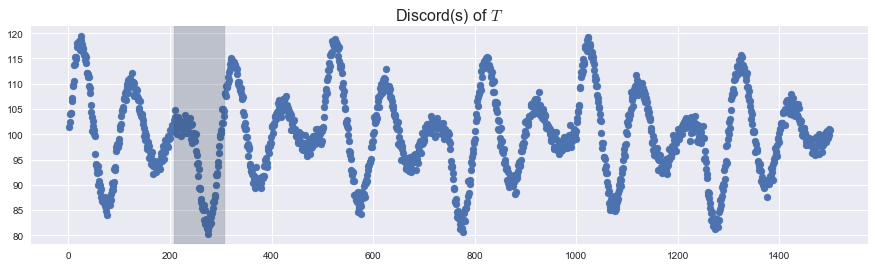

In [9]:
h = 20
n = 100
discords = get_discords(T,n,h)
ax = T.plot_timeseries('Discord(s) of $T$')
for discord in discords:
    ax = discord.shade_subsequence(ax=ax)
plt.show()

When run many times, occasionally two discords will be found. This simply means that the two subsequences are both each other's nearest neighbor (and thus have the same separation distance), and that their distance from each other is greater than their distances from any other subsequences.

We can test this algorithm further by arbitrarily inserting an anomaly into the time series $T$. Let's run the procedure for several lengths of the anomaly to check that it correctly finds the unusual sequence.

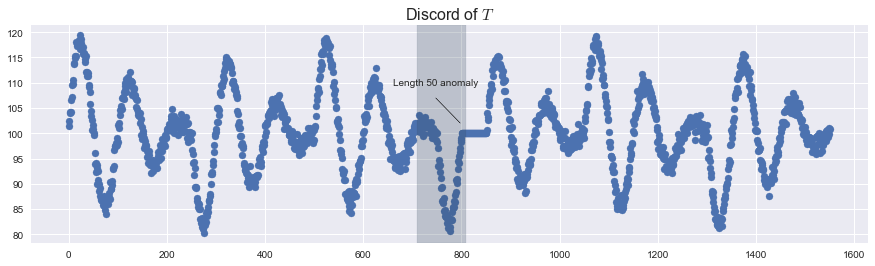

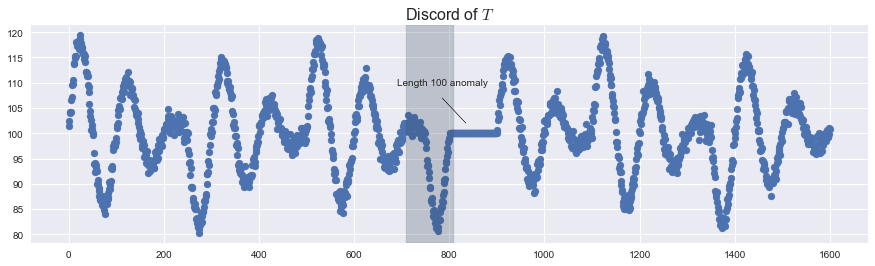

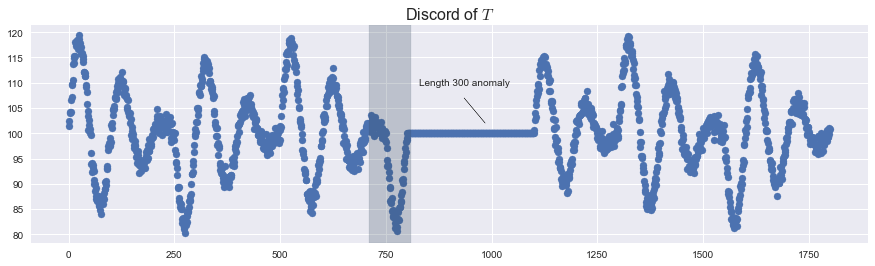

In [10]:
h = 20
n = 100
for anomaly_len in [50,100,300]:
    times = np.arange(m+anomaly_len)+1
    obs = np.concatenate((observations[:800],100*np.ones(anomaly_len),observations[800:]))
    T_anomaly = TimeSeries(times,obs)
    # Only plot the first discord
    discord = get_discords(T_anomaly,n,h)[0]
    discord.plot_timeseries('Discord of $T$')
    anomaly_ax = discord.shade_subsequence()
    anomaly_ax.text(710+0.75*anomaly_len,110,f'Length {anomaly_len} anomaly', 
                    horizontalalignment='center',verticalalignment='center')
    anomaly_ax.arrow(710+0.75*anomaly_len,107,50,-5)
    plt.show()

The algorithm locates the discord every time, though the discord subsequence does not often contain anomaly, it just finds an edge. This behavior is due to a combination of the fact that the threshold disqualifies subsequences that are too distant from other subsequences, and that for longer anomalies, the anomalous points may match with other anomalous points and thus not be considered anomalous. In fact, for larger windows (try $n=200$) the threshold is too low, and the anomaly is entirely excluded as a non-self-match. (This problem could be partially corrected by $z$-normalizing the subsequences (at a loss of discrimination by magnitude) or by $z$-normalizing the entire time series.

Another workaround is to remove the threshold constraint on non-self-matches. This does not introduce considerable harm, since we are already looking at the nearest non-self-matches for all subsequences. By removing the threshold, we just get many more subsequences with acceptable non-self-matches for consideration as the "furthest" nearest neighbor. Since they were previously excluded, these are likely to have high nearest neighbor distances and are therefore good candidates for anomalies. This becomes apparent if we repeat the previous demonstration, but without setting a threshold value for matching.

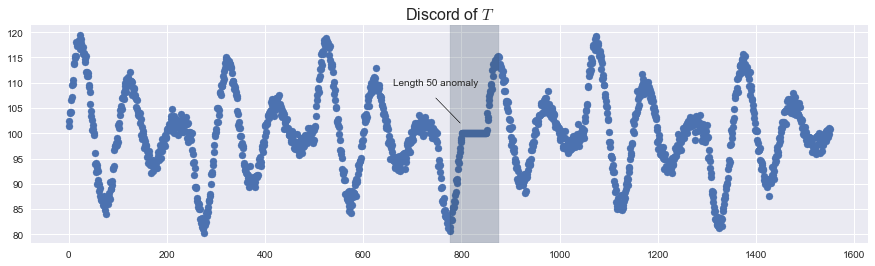

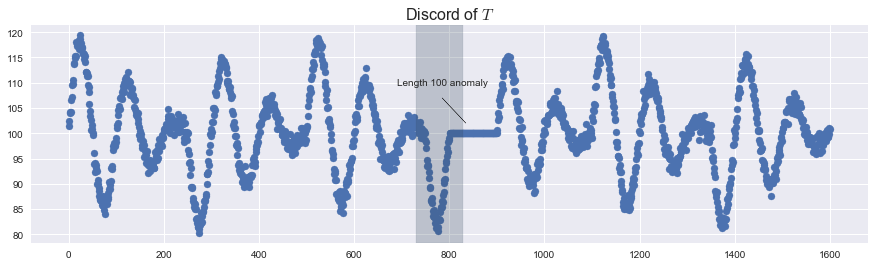

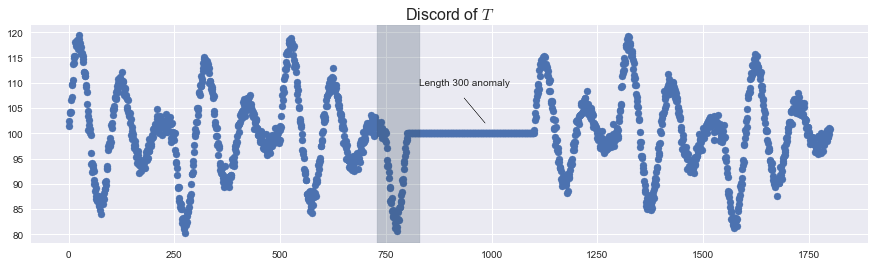

In [11]:
h = None
n = 100
for anomaly_len in [50,100,300]:
    times = np.arange(m+anomaly_len)+1
    obs = np.concatenate((observations[:800],100*np.ones(anomaly_len),observations[800:]))
    T_anomaly = TimeSeries(times,obs)
    # Only plot the first discord
    discord = get_discords(T_anomaly,n,h)[0]
    discord.plot_timeseries('Discord of $T$')
    anomaly_ax = discord.shade_subsequence()
    anomaly_ax.text(710+0.75*anomaly_len,110,f'Length {anomaly_len} anomaly', 
                    horizontalalignment='center',verticalalignment='center')
    anomaly_ax.arrow(710+0.75*anomaly_len,107,50,-5)
    plt.show()

Still, we see that for anomalies approaching the size of the subsequence length and larger, a significant portion of the anomaly has subsequences matching closely with other subsequences in the anomaly and therefore not identified as anomalies.